In [19]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel 
from scipy.stats import gaussian_kde

(35.0, 50.0)

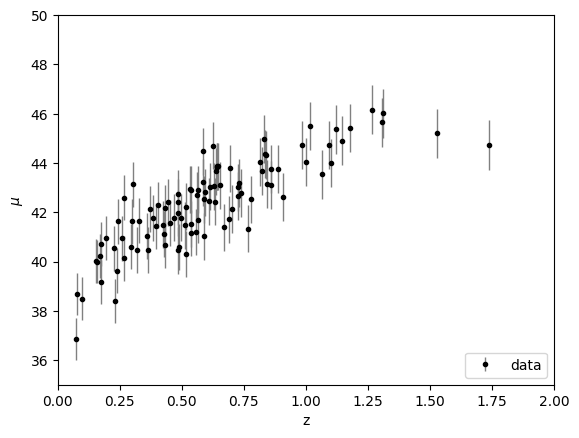

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) ###YOU CAN'T CHANGE THIS

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

In [ ]:
#Costante*RBF+ rumore bianco per l'incertezza dei dati
#C= parte da 1 e ha i limiti 1e-3 a 1e3 rappresenta quanto oscillano mu (altezza, è una costante moltiplicativa)
#RBF controlla quanto varia la curva nel redishift, z va da 0 a 2 quindi intervallo ci sta
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

# 4. Modello GPR
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=dmu**2,  # incertezze sui dati
                              normalize_y=True)  # centra i dati
gp.fit(z_sample.reshape(-1, 1), mu_sample)  # fit del modello

/home/sara/myenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=array([0.84387183, 0.91812087, 0.89001003, 0.94522717, 0.94422381,
       0.86154897, 0.86230499, 0.94838417, 0.9933467 , 0.9646779 ,
       0.87701523, 0.89976228, 0.92772472, 0.93248803, 0.87910942,
       0.90886653, 0.90007965, 0.74796941, 0.94290888, 0.96641079,
       0.87820976, 0.91709206, 0.80479835, 0.87887073, 0.98216481,
       0.92265029, 0.8835475 , 0.94586178, 0.86985...
       0.97119502, 0.88669278, 0.90504074, 0.72518962, 0.86689404,
       0.88987903, 0.91659546, 0.97685316, 0.91867826, 0.93138181,
       0.83270862, 0.93814442, 0.95430226, 0.9199094 , 0.89010136,
       0.83350663, 0.90995601, 0.90388843, 0.98995206, 0.89661359,
       0.90000008, 0.90519576, 0.95184399, 0.79454928, 0.92548723]),
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         normalize_y=True)

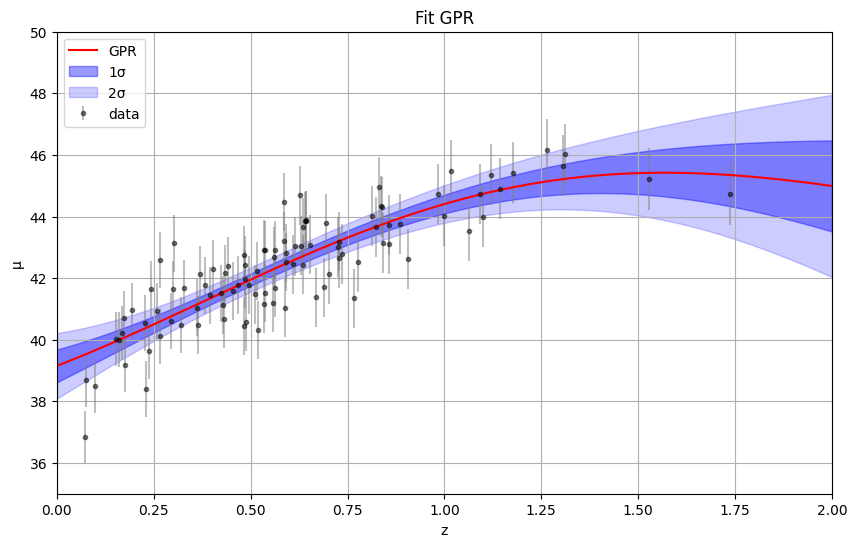

Optimize Kernel: 2.21**2 * RBF(length_scale=1.11) + WhiteKernel(noise_level=1e-05)


In [17]:
z_fit = np.linspace(0, 2, 1000).reshape(-1, 1)  
mu_pred, sigma = gp.predict(z_fit, return_std=True) 
plt.figure(figsize=(10, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt=".k", ecolor='gray', label='data', alpha=0.5)
plt.plot(z_fit, mu_pred, 'r', label="GPR")
plt.fill_between(z_fit.ravel(), mu_pred - sigma, mu_pred + sigma, color='blue', alpha=0.4, label="1σ")
plt.fill_between(z_fit.ravel(), mu_pred - 2*sigma, mu_pred + 2*sigma, color='blue', alpha=0.2, label="2σ")
plt.xlabel("z")
plt.ylabel("μ")
plt.title("Fit GPR")
plt.legend()
plt.grid()
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()
print("Optimize Kernel:", gp.kernel_)

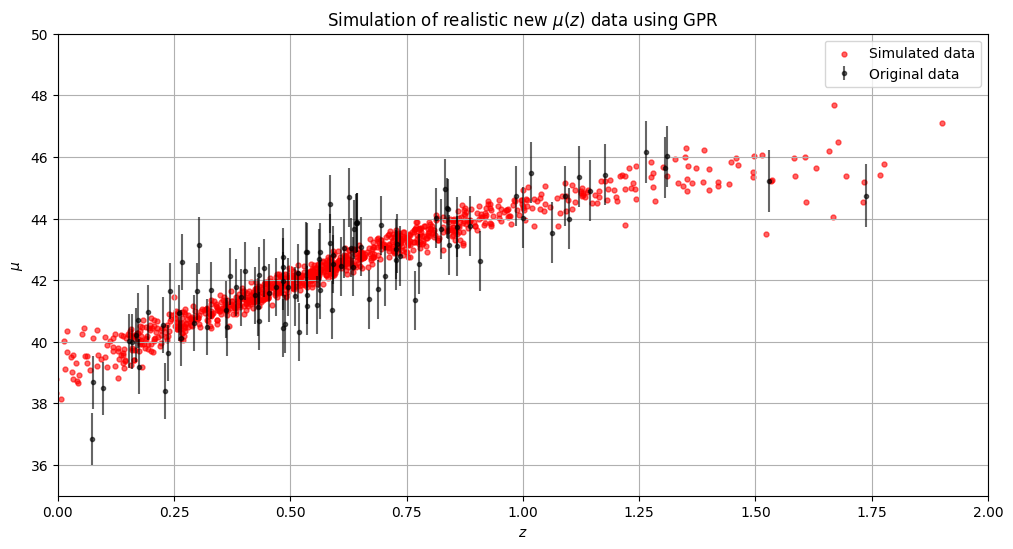

In [ ]:
kde = gaussian_kde(z_sample) #tima la densità di probabilità dei dati
z_new = kde.resample(1000).ravel() # 1000 nuovi valori di redshift campionati da questa pdf stimata.
z_new_sorted = np.sort(z_new) #ordino
 
#  Predizione
mu_new_pred, sigma_new_pred = gp.predict(z_new_sorted.reshape(-1, 1), return_std=True)

#  Simula nuovi mu, Per ogni z_new_sorted, generi un valore simulato di μ campionando da una distribuzione normale con media e deviazione standard date dal modello.
mu_simulated = np.random.normal(mu_new_pred, sigma_new_pred)


plt.figure(figsize=(12, 6))

# Dati originali
plt.errorbar(z_sample, mu_sample,dmu, fmt='.k', alpha=0.6, label='Original data')

# Dati simulati
plt.scatter(z_new_sorted, mu_simulated, color='red', s=50, alpha=0.6, label='Simulated data', marker='.')

plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend()
plt.title("Simulation of realistic new $\mu(z)$ data using GPR")
plt.grid(True)
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.show()

